# Garbage Classification using post-training quantization (with TF2)

This project uses TensorFlow 2 to create an garbage classification model and convert it to TensorFlow Lite using post-training quantization. Finally, we compile it for compatibility with the Edge TPU (available in [Coral devices](https://coral.ai/products/)).

The model is based on a pre-trained version of MobileNet V2. We'll start by retraining only the classification layers, reusing MobileNet's pre-trained feature extractor layers. Then we'll fine-tune the model by updating weights in some of the feature extractor layers. This type of transfer learning is much faster than training the entire model from scratch.

Once it's trained, we'll use post-training quantization to convert all parameters to int8 format, which reduces the model size and increases inferencing speed. This format is also required for compatibility on the Edge TPU. [documentation at coral.ai](https://coral.ai/docs/edgetpu/models-intro/).

<a href="https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>
&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://github.com/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb" target="_parent"><img src="https://img.shields.io/static/v1?logo=GitHub&label=&color=333333&style=flat&message=View%20on%20GitHub" alt="View in GitHub"></a>


## Import the required libraries

In order to quantize both the input and output tensors, we need `TFLiteConverter` APIs that are available in TensorFlow r2.3 or higher:

In [1]:
! pip install pyyaml h5py
! pip install -q kaggle

import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile

vers1 = 'Tensorflow version: {}'.format(tf.__version__)
vers2 = 'Numpy version: {}'.format(np.__version__)
print(vers1)
print(vers2)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

Tensorflow version: 2.5.0
Numpy version: 1.19.5
• GPU Device Found.


## Prepare the training data

First let's download and organize the garbage classification dataset to train the model. It contains 6 garbage classes; cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127). [Garbage Classification Dataset](https://www.kaggle.com/asdasdasasdas/garbage-classification)

Notice that the "Garbage Classification" directory contains an appropriately-named directory for each class. The following code randomizes and divides up the photos into training and validation sets, and generates a labels file based on the photo folder names.

In [2]:
! wget --no-check-certificate \
  https://drive.google.com/u/0/uc?id=1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm&export=download
    
os.rename('uc?id=1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm', 'kaggle.json')
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d asdasdasasdas/garbage-classification

--2021-06-05 12:55:40--  https://drive.google.com/u/0/uc?id=1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm
Resolving drive.google.com (drive.google.com)... 64.233.189.100, 64.233.189.101, 64.233.189.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/le42fiam1r732aemocmv9nc5i3a1ohja/1622897700000/14459494156754265611/*/1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm [following]
--2021-06-05 12:55:41--  https://doc-0o-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/le42fiam1r732aemocmv9nc5i3a1ohja/1622897700000/14459494156754265611/*/1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm
Resolving doc-0o-08-docs.googleusercontent.com (doc-0o-08-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0o-08-docs.googleusercontent.com (doc-0o-08-docs.googleusercontent.com)|64

In [3]:
local_zip = '/content/garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('sampah')
zip_ref.close()

base_dir = '/content/sampah/Garbage classification/Garbage classification'

Next, we use [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1), and call `flow_from_directory()` to create two generators: one for the training dataset and one for the validation dataset. We split 10% dataset for the validation (251 images)

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). We save the class labels to a text file.

In [5]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [6]:
!cat labels.txt

cardboard
glass
metal
paper
plastic
trash

## Build the model

Now we'll create a model that's capable of transfer learning on just the last fully-connected layer. 

We'll start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes). This provides us a great feature extractor for image classification and we can then train a new classification layer with our garbage classification dataset.



### Create the base model 

When instantiating the `MobileNetV2` model, we specify the `include_top = False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable = False` to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

In [7]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


### Add a classification head

Now we create a new [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model and pass the frozen MobileNet model as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in  dataset (6 types of garbage).

In [12]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])

### Configure the model

Although this method is called `compile()`, it's basically a configuration step that's required before we can start training. We can see a string summary of the final network with the `summary()` method:

In [13]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 368,870
Non-trainable params: 2,257,984
_________________________________________________________________


And because the majority of the model graph is frozen in the base model, weights from only the last convolution and dense layers are trainable:

In [14]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


Now we can train the model using data provided by the `train_generator` and `val_generator` that we created at the beginning. 

This should take less than 10 minutes.

In [15]:
checkpoint_path = "/content/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

EPOCHS = 10
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[cp_callback])

Epoch 1/10
36/36 [==============================] - 15s 344ms/step - loss: 1.5231 - accuracy: 0.4288 - val_loss: 1.0232 - val_accuracy: 0.5219

Epoch 00001: saving model to /content/training_1/cp.ckpt
Epoch 2/10
36/36 [==============================] - 11s 310ms/step - loss: 0.9226 - accuracy: 0.6305 - val_loss: 0.7288 - val_accuracy: 0.7450

Epoch 00002: saving model to /content/training_1/cp.ckpt
Epoch 3/10
36/36 [==============================] - 11s 310ms/step - loss: 0.6073 - accuracy: 0.7777 - val_loss: 0.5792 - val_accuracy: 0.7649

Epoch 00003: saving model to /content/training_1/cp.ckpt
Epoch 4/10
36/36 [==============================] - 11s 310ms/step - loss: 0.3922 - accuracy: 0.8629 - val_loss: 0.5803 - val_accuracy: 0.8048

Epoch 00004: saving model to /content/training_1/cp.ckpt
Epoch 5/10
36/36 [==============================] - 11s 308ms/step - loss: 0.2716 - accuracy: 0.9099 - val_loss: 0.4839 - val_accuracy: 0.8287

Epoch 00005: saving model to /content/training_1/cp.

### Review the learning curves


we can see graphs of training and validation results using the `matplotlib` library.

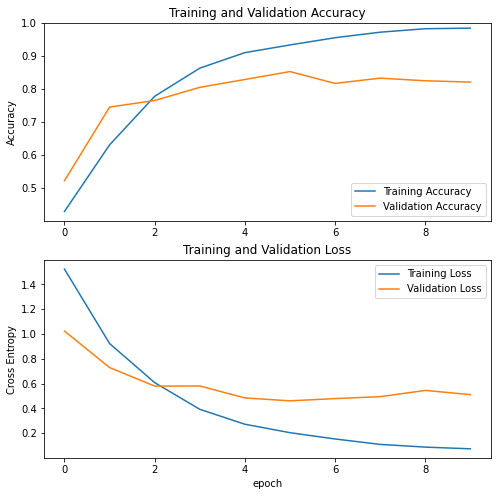

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/graph1.png', dpi=300, bbox_inches='tight')
plt.show()

## Fine tune the base model


So far, we've only trained the classification layers—the weights of the pre-trained network were *not* changed.

One way we can increase the accuracy is to train (or "fine-tune") more layers from the pre-trained model. That is, we'll un-freeze some layers from the base model and adjust those weights (which were originally trained with 1,000 ImageNet classes) so they're better tuned for features found in dataset.

### Un-freeze more layers


So instead of freezing the entire base model, we'll freeze individual layers.

First, let's see how many layers are in the base model:

In [22]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


We freeze just the bottom 100 layers.

In [23]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

Now configure the model again, but this time with a lower learning rate (the default is 0.001).

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 2,230,310
Non-trainable params: 396,544
_________________________________________________________________


In [25]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

Now we fine-tune all trainable layers. This starts with the weights we already trained in the classification layers, so we don't need as many epochs.

In [26]:
checkpoint_path_fine = "/content/training_2/cp.ckpt"
checkpoint_dir_fine = os.path.dirname(checkpoint_path_fine)

cp_callback_fine = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_fine,
                                                 save_weights_only=True,
                                                 verbose=1)

EPOCHS_FINE = 10
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=EPOCHS_FINE,
                         validation_data=val_generator,
                         validation_steps=len(val_generator),
                         callbacks=[cp_callback_fine])

Epoch 1/10
36/36 [==============================] - 17s 363ms/step - loss: 0.1469 - accuracy: 0.9512 - val_loss: 0.4848 - val_accuracy: 0.8566

Epoch 00001: saving model to /content/training_2/cp.ckpt
Epoch 2/10
36/36 [==============================] - 12s 333ms/step - loss: 0.1065 - accuracy: 0.9706 - val_loss: 0.4746 - val_accuracy: 0.8526

Epoch 00002: saving model to /content/training_2/cp.ckpt
Epoch 3/10
36/36 [==============================] - 12s 334ms/step - loss: 0.0773 - accuracy: 0.9855 - val_loss: 0.4704 - val_accuracy: 0.8566

Epoch 00003: saving model to /content/training_2/cp.ckpt
Epoch 4/10
36/36 [==============================] - 12s 334ms/step - loss: 0.0693 - accuracy: 0.9846 - val_loss: 0.4635 - val_accuracy: 0.8566

Epoch 00004: saving model to /content/training_2/cp.ckpt
Epoch 5/10
36/36 [==============================] - 12s 335ms/step - loss: 0.0547 - accuracy: 0.9899 - val_loss: 0.4533 - val_accuracy: 0.8526

Epoch 00005: saving model to /content/training_2/cp.

### Review the new learning curves and save the model

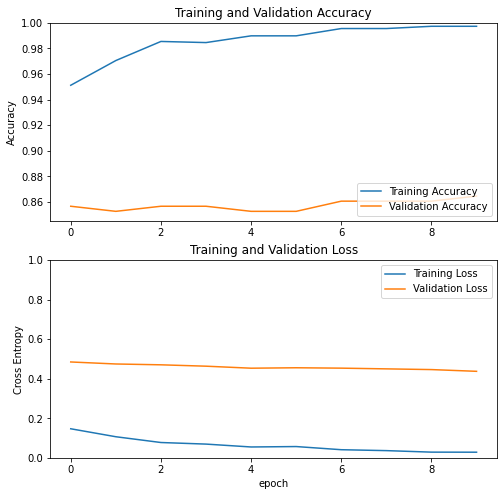

In [27]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/graph2.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
model.save('/content/si_limbah')
model.save('/content/si_limbah.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/si_limbah/assets


INFO:tensorflow:Assets written to: /content/si_limbah/assets


This is better, but it's not ideal.

The validation loss is still higher than the training loss, so there could be some overfitting during training. The overfitting might also be because the new training set is relatively small with less intra-class variance, compared to the original ImageNet dataset used to train MobileNet V2.

And then we can convert the model to TensorFlow Lite.

## Convert to TFLite

Ordinarily, creating a TensorFlow Lite model is just a few lines of code with [`TFLiteConverter`](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter). For example, this creates a basic (un-quantized) TensorFlow Lite model:

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('si_limbah.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpas56wd_k/assets


INFO:tensorflow:Assets written to: /tmp/tmpas56wd_k/assets


However, this `.tflite` file still uses floating-point values for the parameter data, and we need to fully quantize the model to int8 format.

To fully quantize the model, we need to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with a representative dataset, which requires a few more arguments for the `TFLiteConverter`, and a function that builds a dataset that's representative of the training dataset. 


In [32]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(base_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('si_limbah_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpjqum6q7g/assets


INFO:tensorflow:Assets written to: /tmp/tmpjqum6q7g/assets


### Compare the accuracy


So now we have a fully quantized TensorFlow Lite model. To be sure the conversion went well, let's evaluate both the raw model and the TensorFlow Lite model. First check the accuracy of the raw model.


In [33]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 92.188%


Now let's check the accuracy of the `.tflite` file, using the same dataset.

However, there's no convenient API to evaluate the accuracy of a TensorFlow Lite model, so this code runs several inferences and compares the predictions against ground truth.

In [34]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('si_limbah_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 87.500%


## Compile for the Edge TPU


Finally, we compile the model for the Edge TPU.

First download the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/) and then compile the model

In [35]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

! edgetpu_compiler si_limbah_quant.tflite

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release


## Download the model

We can download the saved model, converted model, graphs and labels file from Colab. 

In [ ]:
from google.colab import files

files.download('/content/si_limbah.h5')
files.download('si_limbah.tflite')
files.download('si_limbah_quant.tflite')
files.download('si_limbah_quant_edgetpu.log')
files.download('si_limbah_quant_edgetpu.tflite')
files.download('graph1.png')
files.download('graph2.png')
files.download('labels.txt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [42]:
! cp -R si_limbah.h5 /content/drive/MyDrive/Si-Limbah
! cp -R si_limbah.tflite /content/drive/MyDrive/Si-Limbah
! cp -R si_limbah_quant.tflite /content/drive/MyDrive/Si-Limbah
! cp -R si_limbah_quant_edgetpu.log /content/drive/MyDrive/Si-Limbah
! cp -R si_limbah_quant_edgetpu.tflite /content/drive/MyDrive/Si-Limbah
! cp -R graph1.png /content/drive/MyDrive/Si-Limbah
! cp -R graph2.png /content/drive/MyDrive/Si-Limbah
! cp -R labels.txt /content/drive/MyDrive/Si-Limbah
! cp -R /content/training_1/ /content/drive/MyDrive/Si-Limbah
! cp -R /content/training_2/ /content/drive/MyDrive/Si-Limbah
! cp -R /content/si_limbah/ /content/drive/MyDrive/Si-Limbah
! cp -R kaggle.json /content/drive/MyDrive/Si-Limbah

## Reference

[Retrain Classification ptq tf2](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb)

[Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)